# **Binary Prediction of Smoker Status using Bio-Signals**

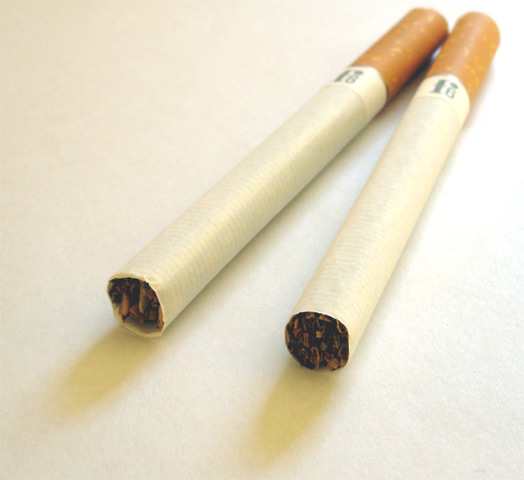

# Introduction

Welcome to the 2023 Kaggle Playground Series! In this exciting competition, participants are tasked with leveraging binary classification to predict a patient's smoking status based on diverse health indicators. The dataset, derived from a deep learning model trained on the Smoker Status Prediction using Bio-Signals dataset, closely mirrors the original feature distributions. However, participants are encouraged to explore potential differences and evaluate whether incorporating the original dataset enhances model performance. The competition involves analyzing the provided train and test datasets, with submissions evaluated on the area under the ROC curve between predicted probabilities and observed targets. Best of luck to all participants in this intriguing challenge!

# Solution Approach

1. Classify the data into numerical and categorical categories and perform data cleaning to ensure completeness.
2. Utilize domain knowledge in the biomedical field to conduct feature engineering and incorporate additional features into the existing dataset. Reference the following notebook for domain knowledge: [Biomedical Knowledge Notebook](https://www.kaggle.com/competitions/playground-series-s3e24/discussion/450314).
3. Apply one-hot encoding to categorical features and employ XGBoost, CatBoost, LightGBM, NN, and a Voting Model to model the data and make predictions.
4. Compare results across different models to identify the optimal solution for decision-making.

In [11]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay


# Some useful functions

In [12]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum()/len(df))
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values

    return sum

In [13]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _ , _= stats.chi2_contingency(contingency_table)

    if p < significance_level:
        print(f'{input_var} has a significant relationship with the target.')
    else:
        print(f'{input_var} does not have a significant relationship with the target.')


In [14]:
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obese-grade 1'
    elif 35 <= bmi < 40:
        return 'Obese-grade 2'
    else:
        return 'Obese-grade 3'


def classify_age(age):
    if age < 45:
        return 'lower_risk'
    else:
        return 'high_risk'
    

def classify_blood_pressure(systolic, diastolic):
    if (systolic < 120) or (diastolic<80):
        return 'normal'
    elif ((systolic>=120) and (systolic<129)) or ((diastolic>=80) and (diastolic<89)):
        return 'elevated'
    elif ((systolic>=130) and (systolic<139)) or ((diastolic>=90) and (diastolic<99)):
        return 'stage_1_high_BP'
    elif ((systolic>=140) and (systolic<179)) or ((diastolic>=100) and (diastolic<119)):
        return 'stage_2_high_BP'
    else:
        return 'emergency'

def classify_total_HDL_LDL(HDL,LDL):
    tot = HDL + LDL
    if tot < 200:
        return 'Desirable'
    elif (tot>=200) and (tot<=239):
        return 'Borderline_high'
    else:
        return 'High'

def classify_HDL(HDL):
    if HDL<40:
        return 'High_risk'
    elif (HDL>=40) and (HDL<60):
        return 'Normal'
    else:
        return 'Low_risk'

    
def classify_LDL(LDL):
    if LDL<100:
        return 'Optimal'
    elif (LDL>=100) and (LDL<=129):
        return 'Near_optimal'
    elif (LDL>=130) and (LDL<=159):
        return 'Borderline_high'
    elif (LDL>=160) and (LDL<=189):
        return 'High'
    else:
        return 'Very_High'

def classify_triglyceride(triglyceride):
    if triglyceride<150:
        return 'normal'
    elif (triglyceride>=150) and (triglyceride<=199):
        return 'moderate_risk'
    elif (triglyceride>=200) and (triglyceride<=499):
        return 'high_risk'
    else:
        return 'very_high_risk'


def classify_hemoglobin(hemoglobin):
    """
    Haemoglobin classification for anemic cases:

    Children aged under 5 years and pregnant women <110 g/L - high risk for anemic case
    Others- <120 g/L - high risk for anemic case
    
    But, here I only use the standard "<120 g/L".
    """
    if hemoglobin<12:
        return 'anemia'
    else:
        return 'normal'

def classify_serum_creatinine(serum_creatinine):
    if (serum_creatinine >= (0.74+0.59)/2) and (serum_creatinine <= (1.35+1.04)/2):
        return 'normal'
    else:
        return 'abnormal'
    

def classify_Gtp(Gtp):
    if (Gtp>=5) and (Gtp<=40):
        return 'normal'
    elif Gtp>40:
        return 'risky_for_liver_disease'
    else:
        return 'too_low'
    

def classify_AST_ALT_levels(AST_or_ALT):
    if (AST_or_ALT>=8) and (AST_or_ALT<=45):
        return 'normal'
    elif AST_or_ALT>45:
        return 'risk_for_liver_disease'
    else:
        return 'too_low'

In [15]:
def plot_count(df, cat_var, hue):
    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)
    for i in range(1,17):
            plt.subplot(4,4,i)
            sns.countplot(data=df, x=cat_var[i-1], hue=TARGET) # target = 'extent'
            plt.title(f'Countplot for {cat_var[i-1]}', fontsize=8)
            plt.ylabel('Count', fontsize=8)
            plt.xticks(rotation=45, fontsize=8)
            plt.yticks(fontsize=5)
            plt.legend(fontsize=5)
            
    plt.show()

In [16]:
def plot_distribution(df, num_var, target):
    fig = plt.figure(figsize=(15, 20))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)
    for i in range(1, 20):
        plt.subplot(10, 2, i)
        sns.histplot(data=df, x=num_var[i-1], kde=True, hue=target, element="step", stat="density", common_norm=False, legend=True)
        plt.title(f'Distribution for {num_var[i-1]}', fontsize=8)
        plt.xlabel('Value', fontsize=8)
        plt.ylabel('Density', fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=5)
        
    plt.show()

In [17]:
# split data into train and validation
def split_dataframe(df):
    df_train = df.sample(frac=0.9,replace=False,random_state=69)
    df_val = df.drop(df_train.index)
    return df_train,df_val

# Exploratory Data Analysis

In [18]:
train = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")
original_train = pd.read_csv("/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv")

Upon preliminary examination, there are no missing or duplicate values:

In [19]:
summary(original_train).style.background_gradient(axis=None)

,dtypes,missing#,missing%,uniques,count
age,int64,0,0.000000,14,38984
height(cm),int64,0,0.000000,13,38984
weight(kg),int64,0,0.000000,22,38984
waist(cm),float64,0,0.000000,545,38984
eyesight(left),float64,0,0.000000,19,38984
eyesight(right),float64,0,0.000000,17,38984
hearing(left),int64,0,0.000000,2,38984
hearing(right),int64,0,0.000000,2,38984
systolic,int64,0,0.000000,125,38984
relaxation,int64,0,0.000000,94,38984


In [20]:
summary(train).style.background_gradient(axis=None)

,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,159256,159256
age,int64,0,0.000000,18,159256
height(cm),int64,0,0.000000,14,159256
weight(kg),int64,0,0.000000,28,159256
waist(cm),float64,0,0.000000,531,159256
eyesight(left),float64,0,0.000000,20,159256
eyesight(right),float64,0,0.000000,17,159256
hearing(left),int64,0,0.000000,2,159256
hearing(right),int64,0,0.000000,2,159256
systolic,int64,0,0.000000,112,159256


In [21]:
train = pd.concat([train, original_train])

The pie chart below reveals a roughly balanced distribution in the dataset, with a smoking rate of 43.7% and a non-smoking rate of 56.3% :

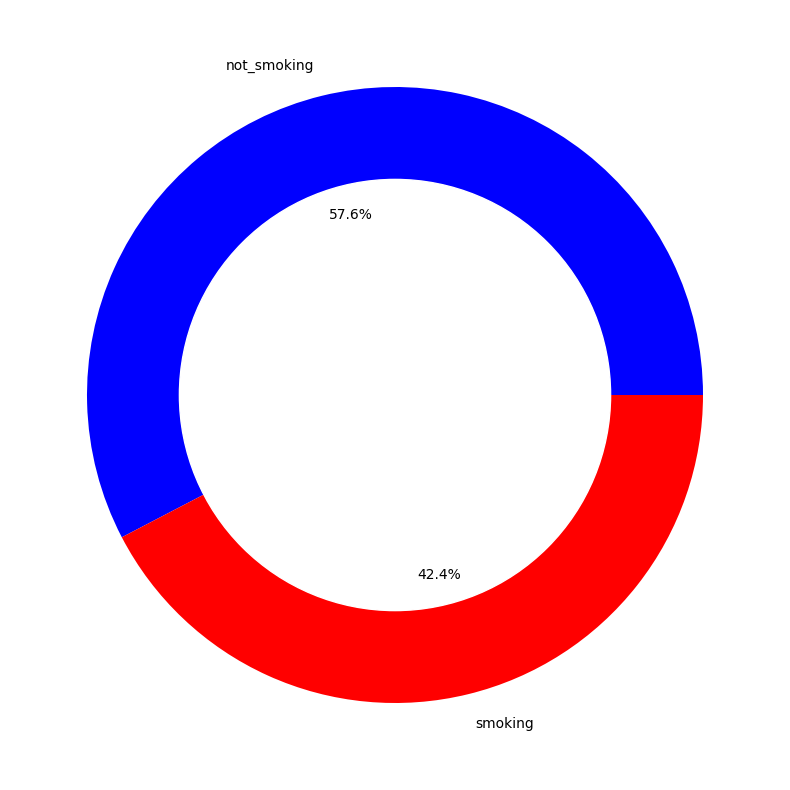

In [22]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train["smoking"].value_counts(), labels=['not_smoking', 'smoking'], colors=['blue','red'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [23]:
categorical_col= ['Urine protein','dental caries','hearing(left)','hearing(right)']

In [24]:
train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [25]:
#Description of Numerical data
train.drop(['smoking','id'],axis=1).drop( categorical_col ,axis = 1).describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
age,198240.000000,44.271418,11.886308,20.000000,40.000000,40.000000,55.000000,85.000000
height(cm),198240.000000,165.153375,8.895587,130.000000,160.000000,165.000000,170.000000,190.000000
weight(kg),198240.000000,66.906709,12.656868,30.000000,55.000000,65.000000,75.000000,135.000000
waist(cm),198240.000000,82.817163,9.039363,51.000000,77.000000,83.000000,89.000000,129.000000
eyesight(left),198240.000000,1.007599,0.422827,0.100000,0.800000,1.000000,1.200000,9.900000
eyesight(right),198240.000000,1.002519,0.414241,0.100000,0.800000,1.000000,1.200000,9.900000
systolic,198240.000000,122.301488,12.920634,71.000000,113.000000,121.000000,130.000000,233.000000
relaxation,198240.000000,76.701085,9.135720,40.000000,70.000000,77.000000,82.000000,146.000000
fasting blood sugar,198240.000000,98.547180,16.514779,46.000000,90.000000,96.000000,103.000000,423.000000
Cholesterol,198240.000000,196.009988,30.131156,55.000000,175.000000,196.000000,217.000000,445.000000


In [26]:
#Description of  Categorical data
train.drop('id',axis=1)[categorical_col].astype('object').describe(include = 'object')

,Urine protein,dental caries,hearing(left),hearing(right)
count,198240,198240,198240,198240
unique,6,2,2,2
top,1,0,1,1
freq,187698,158349,193433,193489


Remove outliers from numerical data to ensure that values are within a reasonable range :

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),
 [Text(1, 0, 'age'),
  Text(2, 0, 'height(cm)'),
  Text(3, 0, 'weight(kg)'),
  Text(4, 0, 'waist(cm)'),
  Text(5, 0, 'eyesight(left)'),
  Text(6, 0, 'eyesight(right)'),
  Text(7, 0, 'hearing(left)'),
  Text(8, 0, 'hearing(right)'),
  Text(9, 0, 'systolic'),
  Text(10, 0, 'relaxation'),
  Text(11, 0, 'fasting blood sugar'),
  Text(12, 0, 'Cholesterol'),
  Text(13, 0, 'triglyceride'),
  Text(14, 0, 'HDL'),
  Text(15, 0, 'LDL'),
  Text(16, 0, 'hemoglobin'),
  Text(17, 0, 'Urine protein'),
  Text(18, 0, 'serum creatinine'),
  Text(19, 0, 'AST'),
  Text(20, 0, 'ALT'),
  Text(21, 0, 'Gtp'),
  Text(22, 0, 'dental caries'),
  Text(23, 0, 'smoking')])

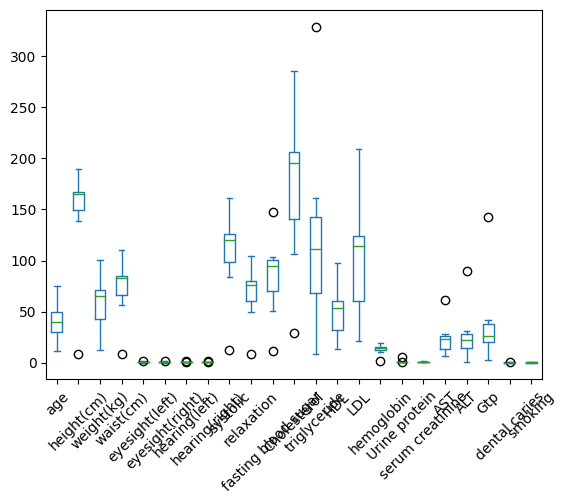

In [27]:
# Remove outliers beyond three standard deviations.
train_without_outlier = train[(np.abs(stats.zscore(train.drop(categorical_col,axis=1).drop(['id'],axis=1))) < 3).all(axis=1)] 
# ( < 3).all(axis=1) checks if, for each row, all column values are within 3 standard deviations from the mean

train_without_outlier.drop(['id'],axis=1).describe().drop('count', axis=0).plot(kind='box')
plt.xticks(rotation=45)

In [28]:
for i in categorical_col:
    chi_squared_test(df=train, input_var=i, target_var='smoking')

Urine protein has a significant relationship with the target.
dental caries has a significant relationship with the target.
hearing(left) has a significant relationship with the target.
hearing(right) has a significant relationship with the target.


Select the top 10 features most correlated with 'smoking,' and arrange them in descending order based on the absolute values of their correlation coefficients :

In [29]:
# 計算與smoking的相關性，由大到小排列
new_corr = train_without_outlier.drop(['id'],axis=1).corr()

new_top_corrs = abs(new_corr["smoking"]).sort_values(ascending = False) 
print(new_top_corrs)

smoking                1.000000
hemoglobin             0.445585
height(cm)             0.435556
Gtp                    0.351641
weight(kg)             0.343974
triglyceride           0.311823
serum creatinine       0.281126
HDL                    0.259730
waist(cm)              0.253078
age                    0.197397
ALT                    0.184651
eyesight(right)        0.135890
eyesight(left)         0.126341
dental caries          0.106838
relaxation             0.103466
fasting blood sugar    0.092685
LDL                    0.073616
systolic               0.058964
Cholesterol            0.058856
AST                    0.053294
hearing(left)          0.031291
hearing(right)         0.030318
Urine protein          0.024884
Name: smoking, dtype: float64


Plot a heatmap of the top 10 features most correlated with 'smoking':

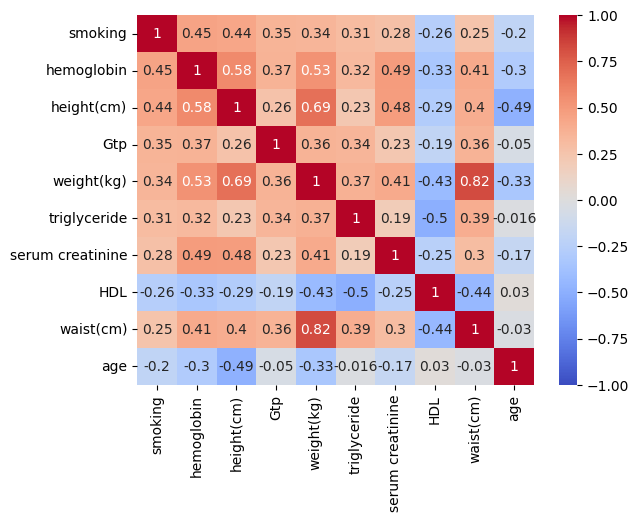

In [30]:
N = 10
#display(new_corr[list(new_top_corrs.head(N).index)].loc[list(new_top_corrs.head(N).index)]) #.iloc[:N,:])
most_important_feature = list(new_top_corrs.head(N).index)
#prit(most_important_feature)
sns.heatmap(new_corr[new_top_corrs.head(N).index].loc[new_top_corrs.head(N).index] , vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm') # 你可以再加上annot = True，這樣corr value就可以被畫出來。

plt.show()

Extract features by using domain knowledge and combine train and test data, perform feature extraction, and one-hot encoding: 

In [31]:
merged_df = pd.concat([train_without_outlier, test], axis=0)

# Use "apply" function to add new features
merged_df['BMI'] = merged_df['weight(kg)'] / ((merged_df['height(cm)'] / 100) ** 2)
merged_df['BMI_Category'] = merged_df['BMI'].apply(classify_bmi)
merged_df['health_risk'] = merged_df['age'].apply(classify_age)
merged_df['classify_blood_pressure'] = merged_df.apply(lambda x: classify_blood_pressure(x.systolic, x.relaxation), axis=1)
merged_df['classify_total_HDL_LDL'] = merged_df.apply(lambda x: classify_total_HDL_LDL(x.HDL, x.LDL), axis=1)
merged_df['classify_HDL'] = merged_df['HDL'].apply(classify_HDL)
merged_df['classify_LDL'] = merged_df['LDL'].apply(classify_LDL)
merged_df['classify_triglyceride'] = merged_df['triglyceride'].apply(classify_triglyceride)
merged_df['classify_hemoglobin'] = merged_df['hemoglobin'].apply(classify_hemoglobin)
merged_df['classify_serum_creatinine'] = merged_df['serum creatinine'].apply(classify_serum_creatinine)
merged_df['classify_Gtp'] = merged_df['Gtp'].apply(classify_Gtp)
merged_df['classify_AST'] = merged_df['AST'].apply(classify_AST_ALT_levels)
merged_df['classify_ALT'] = merged_df['ALT'].apply(classify_AST_ALT_levels)

# Add new feature in categorical features list
categorical_col = categorical_col + ['BMI_Category', 'health_risk', 'classify_blood_pressure', 'classify_total_HDL_LDL', 'classify_HDL', 'classify_LDL', 'classify_triglyceride', 'classify_hemoglobin', 'classify_serum_creatinine', 'classify_Gtp', 'classify_AST', 'classify_ALT']

# Get featured data set for visualization
featured_train = merged_df.iloc[:len(train_without_outlier)]

# Encoding data
encoded_merged_df = merged_df
for feature in categorical_col:
    encoded_merged_df = pd.get_dummies(encoded_merged_df, columns=[feature])

# 將train_enc 和 test_enc 拆開來
train_enc = encoded_merged_df.iloc[:len(train_without_outlier)]
test_enc = encoded_merged_df.iloc[len(train_without_outlier):]

Histogram of categorical features by group:

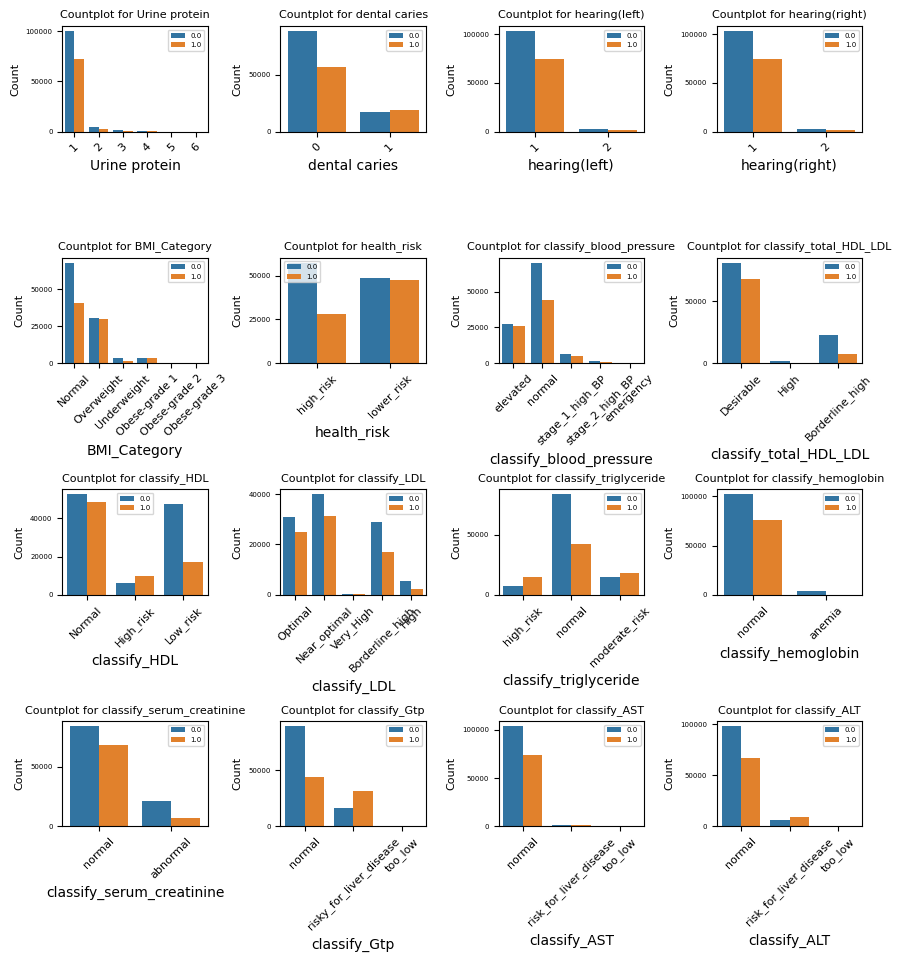

In [32]:
TARGET = 'smoking'            
plot_count(df=featured_train, cat_var=categorical_col, hue=TARGET)

Histogram of numerical features by group :

In [34]:
numerical_col = [feat for feat in list(featured_train.columns) if feat not in categorical_col]
numerical_col.remove('id')
numerical_col.remove('smoking')
print("#numerical_col is ",len(numerical_col))
print(numerical_col)

#numerical_col is  19
['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'BMI']


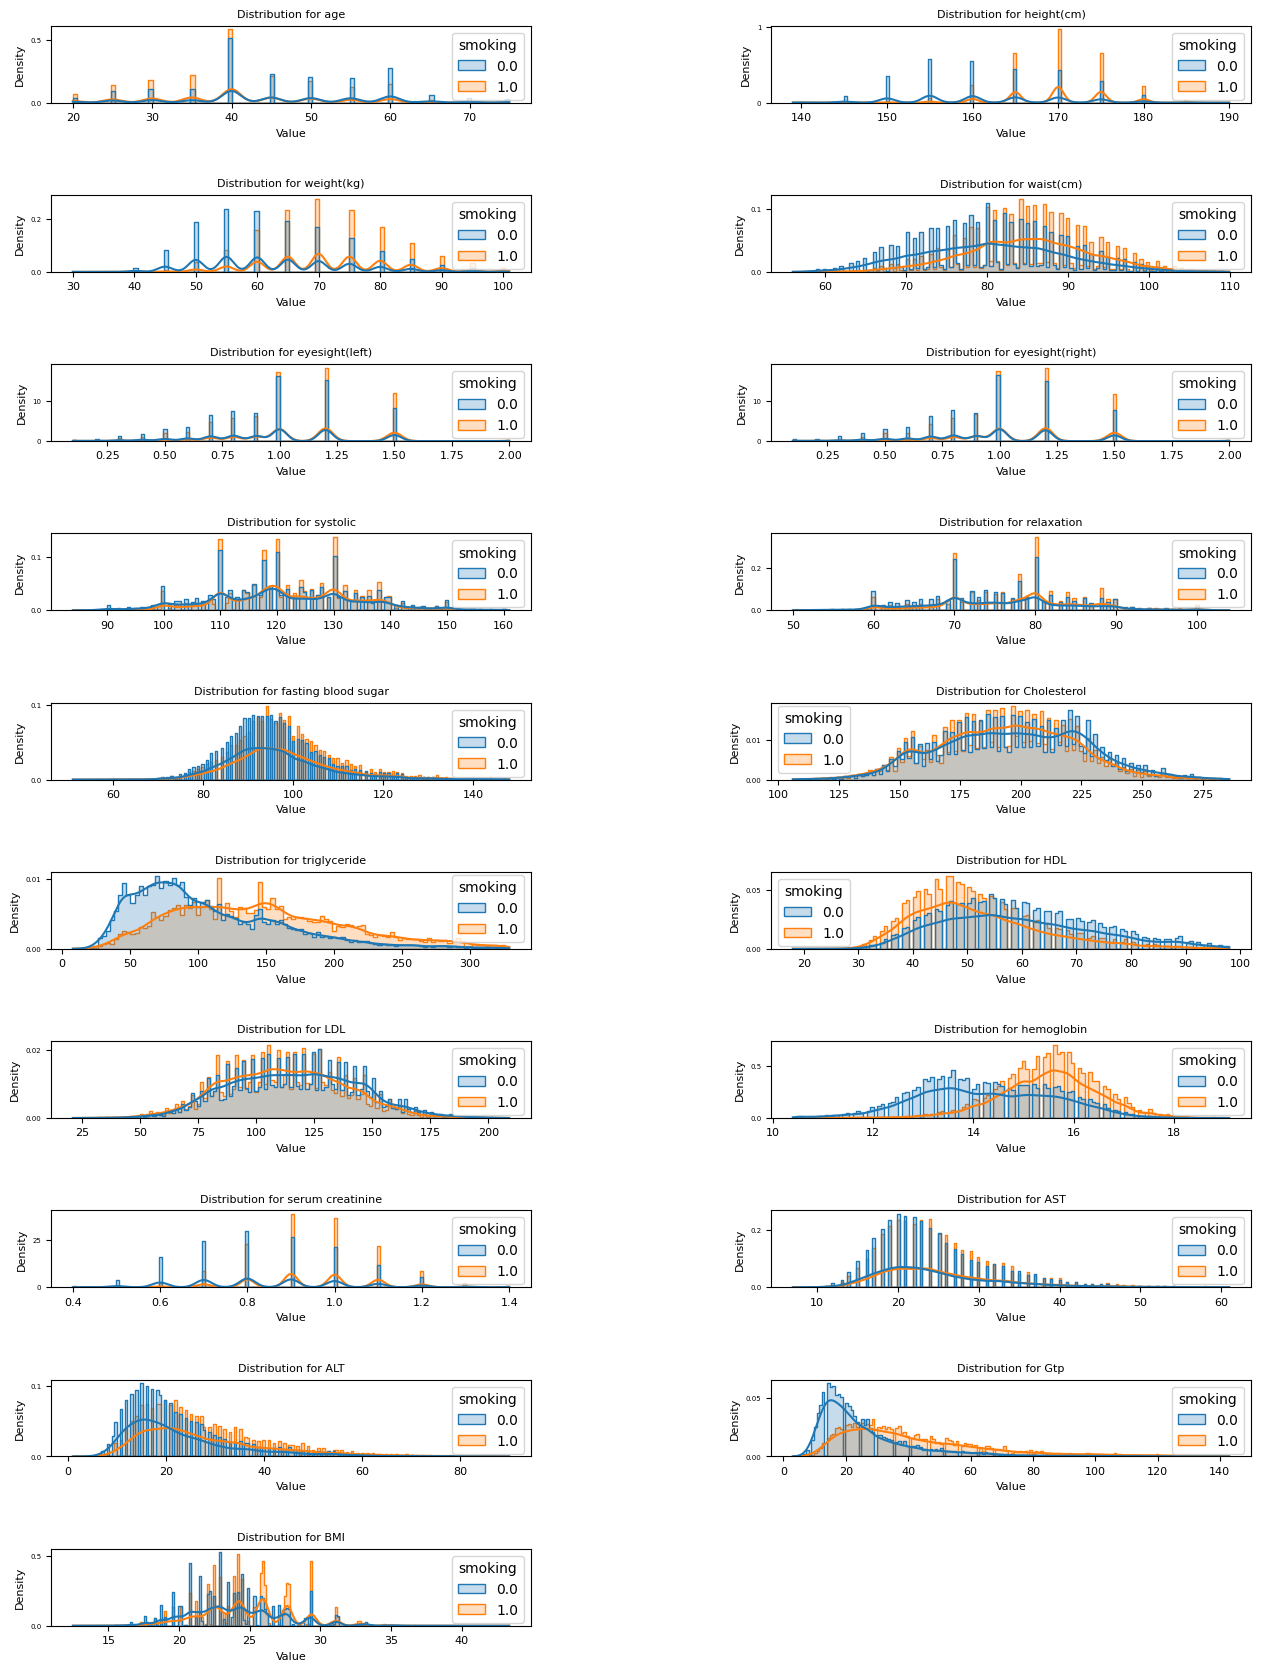

In [35]:
plot_distribution(df=featured_train, num_var=numerical_col, target=TARGET)

Because we cannot ascertain whether the data adheres to the assumption of a normal distribution, we opted for the Mann-Whitney U test instead of the t-test.

In [46]:
from scipy.stats import mannwhitneyu

result_df = pd.DataFrame(columns=['Feature', 'U_statistic', 'P_value'])

for feat in numerical_col:
    # 分割資料為抽菸者和非抽菸者
    smokers_hemoglobin = featured_train[featured_train['smoking'] == 1][feat]
    non_smokers_hemoglobin = featured_train[featured_train['smoking'] == 0][feat]

    # Mann-Whitney U 檢定
    u_statistic, p_value_mannwhitneyu = mannwhitneyu(smokers_hemoglobin, non_smokers_hemoglobin)
    
    result_df = pd.concat([result_df, pd.DataFrame({'Feature': [feat], 'U_statistic': [u_statistic], 'P_value': [p_value_mannwhitneyu]})])
    
    #print(f"{feat} : \n Mann-Whitney U test：u_statistic = {u_statistic}, p_value = {p_value_mannwhitneyu}","\n")

result_df.reset_index(drop=True, inplace=True)

display(result_df)

,Feature,U_statistic,P_value
0,age,3.082136e+09,0.000000e+00
1,height(cm),6.028923e+09,0.000000e+00
2,weight(kg),5.661578e+09,0.000000e+00
3,waist(cm),5.193566e+09,0.000000e+00
4,eyesight(left),4.596714e+09,0.000000e+00
5,eyesight(right),4.646711e+09,0.000000e+00
6,systolic,4.298419e+09,4.981217e-155
7,relaxation,4.504524e+09,0.000000e+00
8,fasting blood sugar,4.487281e+09,0.000000e+00
9,Cholesterol,3.739442e+09,4.421836e-130


In accordance with the Mann-Whitney U, it is observed that the mean values of all numerical features between the smoking and non-smoking groups are significantly different (all p-values < 0.05).

In [ ]:
df_train,df_val = split_dataframe(df=train_enc)

In [26]:
X_train = df_train.drop(['smoking', 'id'],axis=1)
y_train = df_train['smoking']
X_val = df_val.drop(['smoking','id'],axis=1)
y_val = df_val['smoking']

# Modeling : XGBoost

In [29]:
!pip install xgboost

In [30]:
from xgboost import XGBClassifier

In [31]:
eval_set = [(X_val,y_val)]
# tree_method = 'gpu_hist'
xgbc = XGBClassifier(eval_metric='auc', learning_rate= 0.1, max_depth=6, min_child_weight=2)

In [32]:
# eval_metric="auc"
xgbc.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The top 20 most important features in XGBoost, as determined by the dominant node split.

Text(0.5, 1.0, 'Feature Importance')

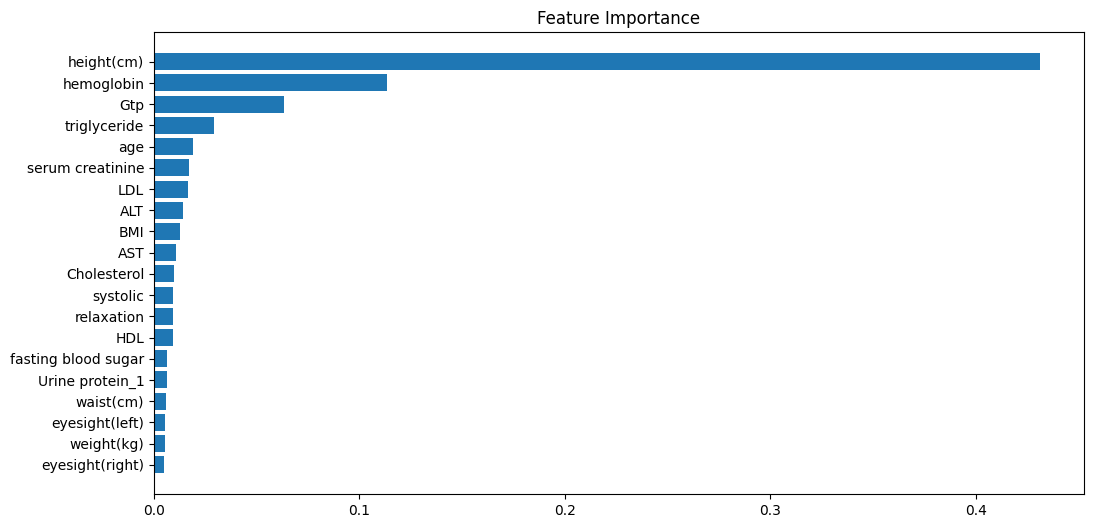

In [33]:
feature_importance = xgbc.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [34]:

# 預測概率分數
y_pred_prob = xgbc.predict_proba(X_val)[:, 1]
print(y_pred_prob)
# 計算AUC
auc = roc_auc_score(y_val, y_pred_prob)

print("AUC:", auc)
print("Accuracy:", xgbc.score(X_val, y_val))

[0.73997957 0.04879488 0.9088101  ... 0.13847029 0.02402517 0.38163885]
AUC: 0.8618045857316992
Accuracy: 0.7819632881085395


Confusion matrix, without normalization
[[5463 1654]
 [1078 4335]]
Normalized confusion matrix
[[0.76759871 0.23240129]
 [0.19915019 0.80084981]]


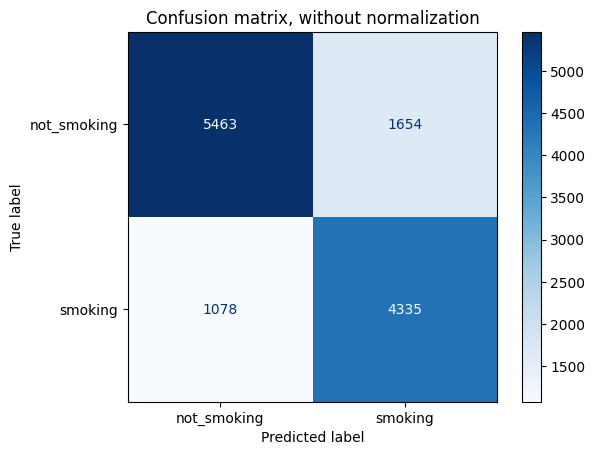

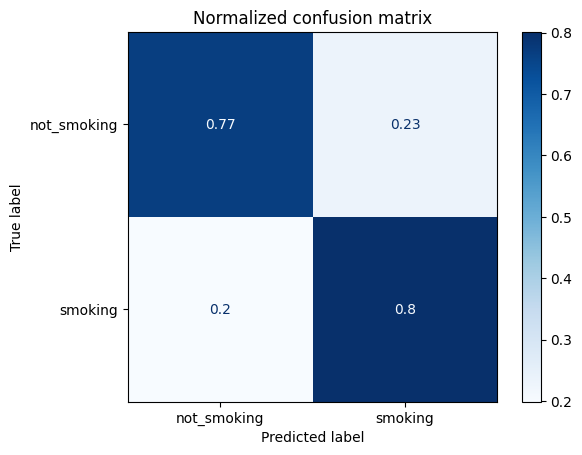

In [35]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        xgbc,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('xgbc_normalized_confusion.png')    
plt.show()



In [36]:
# xgboost submission
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
#xgbc_y_pred = xgbc.predict(test_enc.drop(['id', 'smoking'],axis=1))
xgbc_y_pred = xgbc.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(xgbc_y_pred, columns = ['smoking'])

xgbc_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(xgbc_submission)
xgbc_submission.to_csv('/kaggle/working/xgbc_submission.csv',index=False)


,id,smoking
0,159256.0,0.606606
1,159257.0,0.250741
2,159258.0,0.433435
3,159259.0,0.028028
4,159260.0,0.518222
...,...,...
106166,265422.0,0.529745
106167,265423.0,0.572432
106168,265424.0,0.474387
106169,265425.0,0.109262


# Modeling : CatBoost

In [37]:
!pip install catboost

In [38]:
from catboost import CatBoostClassifier

In [39]:
cbc = CatBoostClassifier(task_type="CPU", learning_rate=0.05, depth=6, random_state=42, #iterations=200, 
                         n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=True)
history = cbc.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The top 20 most important features in CatBoost, as determined by the dominant node split.

Text(0.5, 1.0, 'Feature Importance')

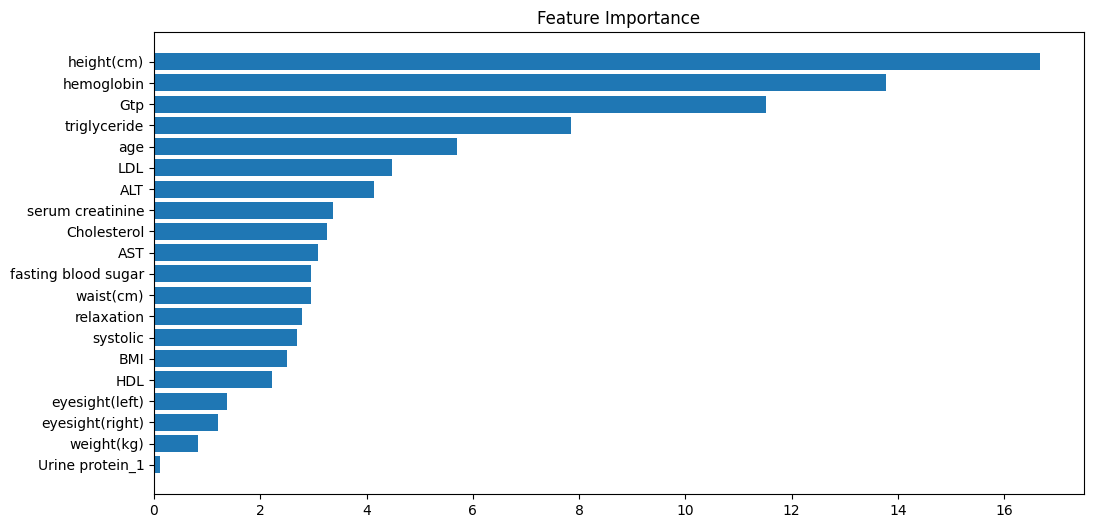

In [40]:
feature_importance = cbc.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [41]:
# 預測概率分數
y_pred_prob = cbc.predict_proba(X_val)[:, 1]
print(y_pred_prob)
# 計算AUC
auc = roc_auc_score(y_val, y_pred_prob)

print("AUC:", auc)
print("Accuracy:", xgbc.score(X_val, y_val))

[0.73434014 0.03522332 0.94530535 ... 0.09347588 0.02617796 0.40322991]
AUC: 0.8675024278818567
Accuracy: 0.7819632881085395


Confusion matrix, without normalization
[[5540 1577]
 [1143 4270]]
Normalized confusion matrix
[[0.77841787 0.22158213]
 [0.21115832 0.78884168]]


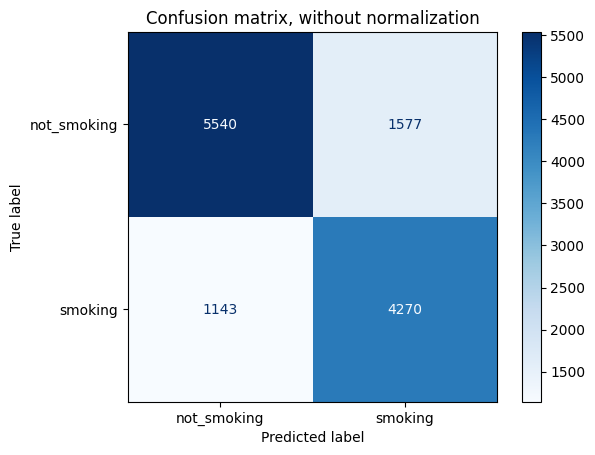

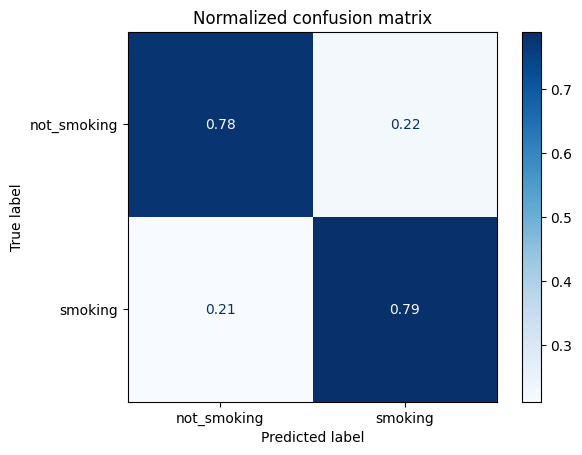

In [42]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        cbc,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('cbc_normalized_confusion.png')    
plt.show()


In [43]:
# catboost submission
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
cbc_y_pred = cbc.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(cbc_y_pred, columns = ['smoking'])

cbc_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(cbc_submission)
cbc_submission.to_csv('/kaggle/working/cbc_submission.csv',index=False)

,id,smoking
0,159256.0,0.571707
1,159257.0,0.467198
2,159258.0,0.276268
3,159259.0,0.020897
4,159260.0,0.555048
...,...,...
106166,265422.0,0.606915
106167,265423.0,0.545713
106168,265424.0,0.427185
106169,265425.0,0.085161


# Modeling : lishtbgm

In [44]:
! pip install lightgbm

In [45]:
import lightgbm as lgb

In [46]:
lgbc = lgb.LGBMClassifier(device = "cpu",learning_rate=0.05, max_depth=6,
                         n_estimators= 2048, metric = 'auc')
lgbc.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)



/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(device='cpu', learning_rate=0.05, max_depth=6, metric='auc',
               n_estimators=2048)

Text(0.5, 1.0, 'Feature Importance')

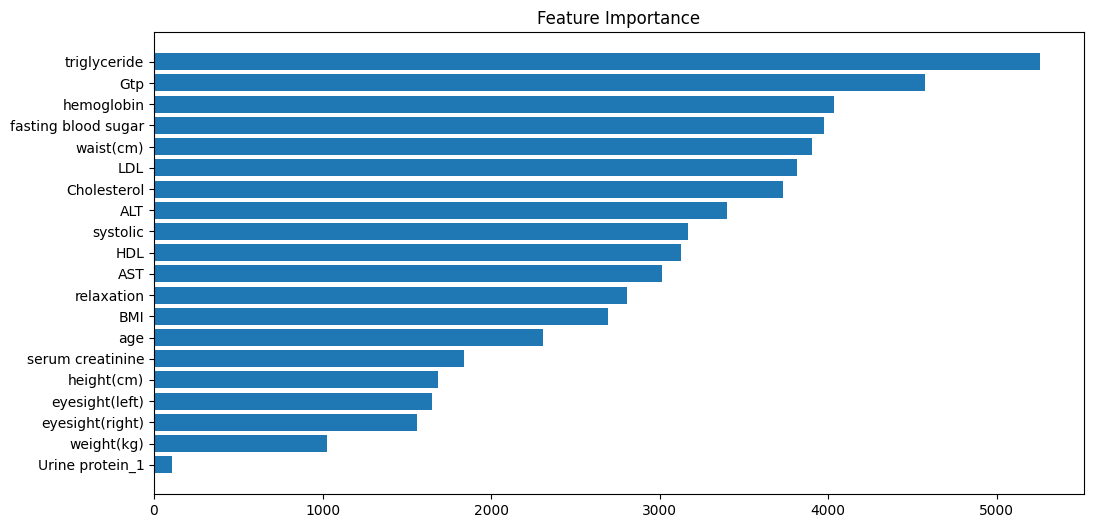

In [47]:
feature_importance = lgbc.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [48]:
# 預測概率分數
y_pred_prob = lgbc.predict_proba(X_val)[:, 1]
print(y_pred_prob)
# 計算AUC
auc = roc_auc_score(y_val, y_pred_prob)

print("AUC:", auc)
print("Accuracy:", lgbc.score(X_val, y_val))

[0.68345084 0.0238613  0.9462861  ... 0.07993032 0.03076046 0.29412662]
AUC: 0.8682749009385526
Accuracy: 0.7868316041500399


Confusion matrix, without normalization
[[5596 1521]
 [1150 4263]]
Normalized confusion matrix
[[0.78628636 0.21371364]
 [0.21245151 0.78754849]]


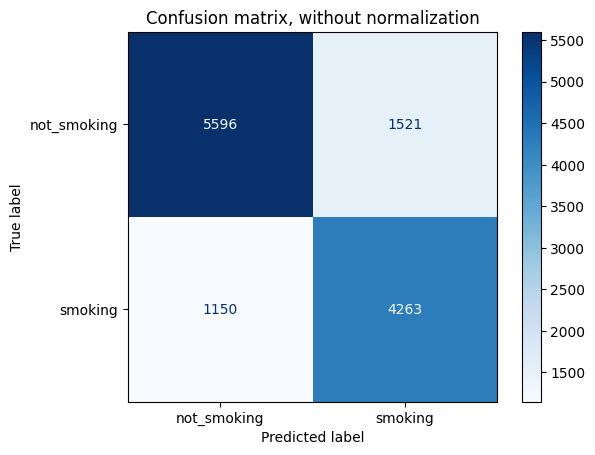

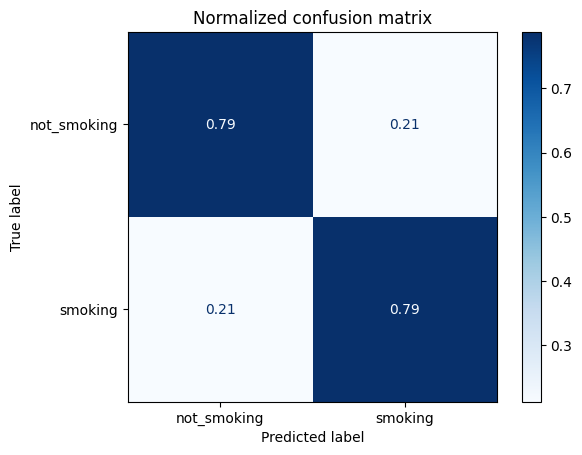

In [49]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        lgbc,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('lgbc_normalized_confusion.png')    
plt.show()


In [50]:
# lightgbm
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
lgbc_y_pred = lgbc.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(lgbc_y_pred, columns = ['smoking'])

lgbc_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(lgbc_submission)
lgbc_submission.to_csv('/kaggle/working/lgbc_submission.csv',index=False)

,id,smoking
0,159256.0,0.662378
1,159257.0,0.393204
2,159258.0,0.367803
3,159259.0,0.014731
4,159260.0,0.564144
...,...,...
106166,265422.0,0.578516
106167,265423.0,0.583189
106168,265424.0,0.503170
106169,265425.0,0.072493


# Modeling : DNN (Tensorflow)

In [51]:
import tensorflow as tf

In [81]:
# Ref : https://www.kaggle.com/code/enricomanosperti/binary-prediction-of-smoker-status-using-bio-signa#Train/test-split
def create_dnn_model():
    dnn_model = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(X_train.shape[1], )),
         tf.keras.layers.Dropout(0.3),
         tf.keras.layers.Dense(24, activation='relu',  kernel_initializer='he_uniform'),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(16, activation='relu',  kernel_initializer='he_uniform'),
         tf.keras.layers.Dense(8, activation='relu',  kernel_initializer='he_uniform'),
         tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    dnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy',tf.keras.metrics.AUC(curve='ROC',from_logits=False
)])
    return dnn_model

In [82]:
dnn = create_dnn_model()
history = dnn.fit(X_train.astype(float), y_train, validation_data=(X_val.astype(float), y_val), epochs=20, batch_size=32)

Epoch 1/20
5106/5106 [==============================] - 19s 3ms/step - loss: 0.5198 - accuracy: 0.7230 - auc_2: 0.8029 - val_loss: 0.4774 - val_accuracy: 0.7610 - val_auc_2: 0.8406
Epoch 2/20
5106/5106 [==============================] - 18s 4ms/step - loss: 0.5035 - accuracy: 0.7379 - auc_2: 0.8180 - val_loss: 0.4699 - val_accuracy: 0.7671 - val_auc_2: 0.8448
Epoch 3/20
5106/5106 [==============================] - 17s 3ms/step - loss: 0.4994 - accuracy: 0.7412 - auc_2: 0.8215 - val_loss: 0.4722 - val_accuracy: 0.7632 - val_auc_2: 0.8445
Epoch 4/20
5106/5106 [==============================] - 17s 3ms/step - loss: 0.4975 - accuracy: 0.7422 - auc_2: 0.8230 - val_loss: 0.4684 - val_accuracy: 0.7667 - val_auc_2: 0.8452
Epoch 5/20
5106/5106 [==============================] - 17s 3ms/step - loss: 0.4975 - accuracy: 0.7420 - auc_2: 0.8226 - val_loss: 0.4758 - val_accuracy: 0.7682 - val_auc_2: 0.8459
Epoch 6/20
5106/5106 [==============================] - 13s 3ms/step - loss: 0.4961 - accuracy:

In [83]:
predicted_probabilities = dnn.predict(X_val.astype(float))
predicted_probabilities = np.squeeze(predicted_probabilities)
print(predicted_probabilities)
roc_auc_score(y_val, predicted_probabilities)

392/392 [==============================] - 1s 1ms/step
[0.73776835 0.06387772 0.8377938  ... 0.19235723 0.03464622 0.518039  ]


0.8489807516659412

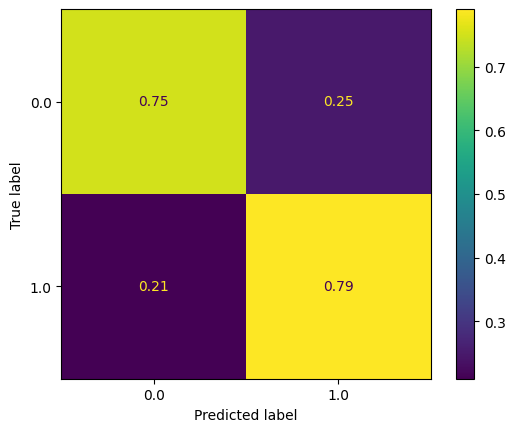

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ['not_smoking', 'smoking'] 

class estimator:
# ref : https://www.kaggle.com/code/mdmashurshalehin/plotting-confusion-matrix-for-tensorflow-model    
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

classifier = estimator(dnn, class_names)



predict_one_zero = np.array([1 if x > 0.5 else 0 for x in list(predicted_probabilities)])
ConfusionMatrixDisplay.from_predictions(y_val, predict_one_zero, normalize='true')

plt.savefig('dnn_normalized_confusion.png')   



In [85]:
# dnn submission
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
dnn_y_pred = dnn.predict(test_enc.drop(['id', 'smoking'],axis=1).astype(float)) #[:, 1]
dnn_y_pred = np.squeeze(dnn_y_pred)
#print(dnn_y_pred)

prediction = pd.DataFrame(cbc_y_pred, columns = ['smoking'])
#print(prediction)

dnn_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(dnn_submission)
dnn_submission.to_csv('/kaggle/working/dnn_submission.csv',index=False)


3318/3318 [==============================] - 5s 1ms/step


,id,smoking
0,159256.0,0.571707
1,159257.0,0.467198
2,159258.0,0.276268
3,159259.0,0.020897
4,159260.0,0.555048
...,...,...
106166,265422.0,0.606915
106167,265423.0,0.545713
106168,265424.0,0.427185
106169,265425.0,0.085161


**Ensemble learning : Averaging method**

In [57]:
#cbc_submission xgbc_submission lgbc_submission dnn_submission

total_pred = pd.concat([cbc_submission['id'], cbc_submission['smoking'], xgbc_submission['smoking'], lgbc_submission['smoking'], dnn_submission['smoking']],axis=1, keys= ['id', 'cbc_smoking', 'xgbc_smoking', 'lgbc_smoking', 'dnn_smoking']) #, ignore_index=False)
display(total_pred)

,id,cbc_smoking,xgbc_smoking,lgbc_smoking,dnn_smoking
0,159256.0,0.571707,0.606606,0.662378,0.571707
1,159257.0,0.467198,0.250741,0.393204,0.467198
2,159258.0,0.276268,0.433435,0.367803,0.276268
3,159259.0,0.020897,0.028028,0.014731,0.020897
4,159260.0,0.555048,0.518222,0.564144,0.555048
...,...,...,...,...,...
106166,265422.0,0.606915,0.529745,0.578516,0.606915
106167,265423.0,0.545713,0.572432,0.583189,0.545713
106168,265424.0,0.427185,0.474387,0.503170,0.427185
106169,265425.0,0.085161,0.109262,0.072493,0.085161


In [58]:
total_pred['average_pred'] = total_pred.apply(lambda x: 0.25*(x.dnn_smoking + x.cbc_smoking + x.xgbc_smoking + x.lgbc_smoking ), axis=1)

In [59]:
ave_submission = total_pred[['id', 'average_pred']].rename({'average_pred': 'smoking'}, axis=1)
ave_submission.to_csv('/kaggle/working/ave_submission.csv',index=False)
display(ave_submission)

,id,smoking
0,159256.0,0.603100
1,159257.0,0.394585
2,159258.0,0.338443
3,159259.0,0.021138
4,159260.0,0.548116
...,...,...
106166,265422.0,0.580523
106167,265423.0,0.561762
106168,265424.0,0.457982
106169,265425.0,0.088019


# Ensemble learning : Voting method (only tree based)

In [60]:
import sklearn 
from sklearn.ensemble import VotingClassifier

In [ ]:
# Voting of 3 tree-based models
xgbc = XGBClassifier(eval_metric='auc',
                     learning_rate= 0.05, 
                     n_estimators= 1024,
                     max_depth=8, 
                     min_child_weight=2,
                     subsample = 0.5)

cbc = CatBoostClassifier(learning_rate=0.05, depth=8, random_state=42, #iterations=200, 
                         task_type="CPU", 
                         n_estimators= 1024, #2048,
                         eval_metric='AUC',
                         use_best_model=False)

lgbc = lgb.LGBMClassifier(device = "cpu", learning_rate=0.05, max_depth=8,
                         n_estimators= 1024,#2048,
                         metric = 'auc')

voting_model = VotingClassifier(verbose=True, estimators=[('cbc', cbc),('xgbc',xgbc), ('lgbc',lgbc)], voting='soft')
voting_model.fit(X_train,y_train)

In [76]:
voting_predicted_probabilities = voting_model.predict_proba(X_val.astype(float))[:, 1]
#voting_predicted_probabilities = np.squeeze(voting_predicted_probabilities)
print(voting_predicted_probabilities)
roc_auc_score(y_val, voting_predicted_probabilities)

[0.71794725 0.02937507 0.94592337 ... 0.10460205 0.03904347 0.41267   ]


0.8694021888146972

Confusion matrix, without normalization
[[5569 1548]
 [1116 4297]]
Normalized confusion matrix
[[0.78249262 0.21750738]
 [0.20617033 0.79382967]]


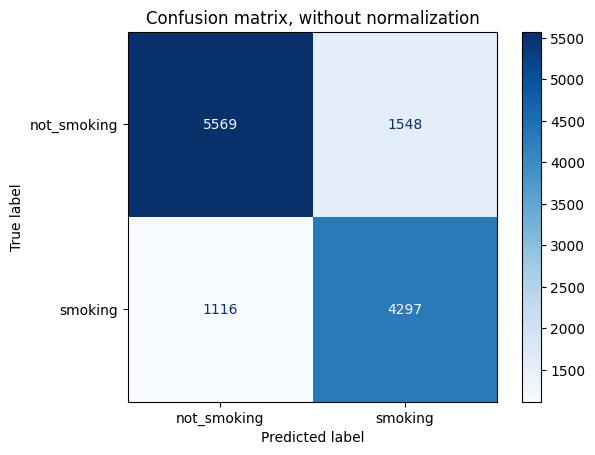

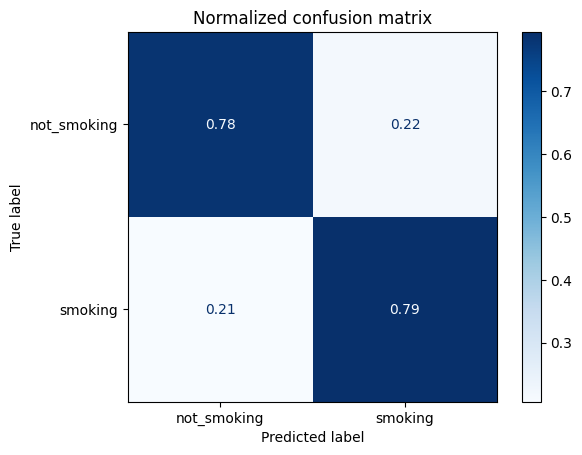

In [77]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        voting_model,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('voting_model_normalized_confusion.png')    
plt.show()


In [78]:
# voting classifier
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
voting_y_pred = voting_model.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(voting_y_pred, columns = ['smoking'])

voting_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(voting_submission)
voting_submission.to_csv('/kaggle/working/voting_submission.csv',index=False)

,id,smoking
0,159256.0,0.663796
1,159257.0,0.480153
2,159258.0,0.400594
3,159259.0,0.011439
4,159260.0,0.557755
...,...,...
106166,265422.0,0.549529
106167,265423.0,0.520006
106168,265424.0,0.486972
106169,265425.0,0.078863


# Ensemble learning : Voting method (DNN and tree based)

In [65]:
from sklearn.neural_network import MLPClassifier

classifiers = []

mlp = MLPClassifier( random_state=123, verbose=1, batch_size=64, #hidden_layer_sizes=(100,2),
                    #max_iter=20,
                    early_stopping = True,
                   alpha = 10.0 ** -3, 
                    hidden_layer_sizes = (12,3), 
                 learning_rate = 'adaptive',
                 learning_rate_init = 1e-4
                   )
classifiers.append(mlp)

xgbc = XGBClassifier(# tree_method = 'gpu_hist' ,
                     eval_metric='auc',
                    learning_rate = 0.3 , 
                    max_depth = 7,#4, 
                    min_child_weight= 5, 
                    n_estimators = 2048
)

classifiers.append(xgbc)

cbc = CatBoostClassifier(task_type="CPU", 
                         learning_rate=0.05, 
                         depth= 7,#4, 
                         random_state=42, #iterations=200, 
                         n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=False)

classifiers.append(cbc)


lgbc = lgb.LGBMClassifier(device = "cpu",
                          learning_rate=0.05, 
                          max_depth= 7,#4,
                          n_estimators= 2048, 
                          metric = 'auc')

classifiers.append(lgbc)

In [66]:
"""
from sklearn.neural_network import MLPClassifier

classifiers = []

mlp = MLPClassifier( random_state=123, verbose=1, batch_size=64, #hidden_layer_sizes=(100,2),
                    #max_iter=20,
                    early_stopping = True)
classifiers.append(mlp)

xgbc = XGBClassifier(# tree_method = 'gpu_hist' ,
                     eval_metric='auc')

classifiers.append(xgbc)

cbc = CatBoostClassifier(random_state=42, #iterations=200, 
                         task_type="CPU", 
                         #n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=False)

classifiers.append(cbc)

lgbc = lgb.LGBMClassifier(device = "cpu",random_state=42, learning_rate=0.05, metric = 'auc')

classifiers.append(lgbc)


parameters=[]
parameters_mlp = {'alpha': 10.0 ** -np.arange(1, 4), 
                'hidden_layer_sizes':[(16,2)], 
                 'learning_rate' : ['constant','adaptive'],
                 'learning_rate_init':[1e-3,1e-4,1e-5]}
parameters.append(parameters_mlp)
parameters_xgbc = {  "learning_rate" : [0.1, 0.3, 0.5], "max_depth" : [4], "min_child_weight" : [1,5,15,200], "n_estimators" : [512] }

parameters.append(parameters_xgbc)
parameters_cbc = {"learning_rate" : [0.1, 0.3, 0.5] , "depth" : [4], # "random_state" : 42, #iterations=200,  
                         "n_estimators" : [512]} #"use_best_model" : [False]
parameters.append(parameters_cbc)
parameters_lgbc = { "learning_rate" : [0.1, 0.3, 0.5] , "max_depth" : [4], "n_estimators" : [512]}
parameters.append(parameters_lgbc)

# ref : https://www.kaggle.com/code/maheshas88/titanic-4-classifier-voting-with-gridsearchcv
#Here grid search is performed for each model. THe best estimator combination for each model
#is stored in a list best_models.
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
def gridSearchCV(models,params,count):
    best_models=[]
    for i in tqdm(range(0,count)): 
        print("model = ",models[i])
        model_grid = GridSearchCV(models[i], parameters[i], n_jobs=-1, verbose=1, cv=5)
        model_grid.fit(X_train,y_train)
        best_models.append(model_grid.best_estimator_)
    return best_models

best_model_list = gridSearchCV(classifiers,parameters,4)
"""

'\nfrom sklearn.neural_network import MLPClassifier\n\nclassifiers = []\n\nmlp = MLPClassifier( random_state=123, verbose=1, batch_size=64, #hidden_layer_sizes=(100,2),\n                    #max_iter=20,\n                    early_stopping = True)\nclassifiers.append(mlp)\n\nxgbc = XGBClassifier(# tree_method = \'gpu_hist\' ,\n                     eval_metric=\'auc\')\n\nclassifiers.append(xgbc)\n\ncbc = CatBoostClassifier(random_state=42, #iterations=200, \n                         task_type="CPU", \n                         #n_estimators= 2048,\n                         eval_metric=\'AUC\',\n                         use_best_model=False)\n\nclassifiers.append(cbc)\n\nlgbc = lgb.LGBMClassifier(device = "cpu",random_state=42, learning_rate=0.05, metric = \'auc\')\n\nclassifiers.append(lgbc)\n\n\nparameters=[]\nparameters_mlp = {\'alpha\': 10.0 ** -np.arange(1, 4), \n                \'hidden_layer_sizes\':[(16,2)], \n                 \'learning_rate\' : [\'constant\',\'adaptive\'],\n   

In [ ]:
vot_clf = VotingClassifier(estimators=[('mlp', classifiers[0]), ('xgbc', classifiers[1]), 
                                       ('cbc', classifiers[2]), ('lgbc', classifiers[3])],
                           voting='soft',n_jobs=-1)

vot_clf.fit(X_train,y_train)

In [ ]:
vot_clf_predicted_probabilities = vot_clf.predict_proba(X_val.astype(float))[:, 1]
#voting_predicted_probabilities = np.squeeze(voting_predicted_probabilities)
print(vot_clf_predicted_probabilities)
roc_auc_score(y_val, vot_clf_predicted_probabilities)

In [ ]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        vot_clf,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('vot_clf_normalized_confusion.png')    
plt.show()


In [ ]:
vot_clf_y_pred = vot_clf.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(vot_clf_y_pred, columns = ['smoking'])

vot_clf_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(vot_clf_submission)
vot_clf_submission.to_csv('/kaggle/working/vot_clf_submission.csv',index=False)

# Summary

The AUC scores of the three tree-based methods show minimal differences when the tree size is kept constant. When utilizing a voting model combining the three, the test set score reaches 87.068%, slightly surpassing the individual scores of each tree-based model (around 86%). Furthermore, incorporating the DNN model into the voting ensemble results in a slightly lower score of 87.054% compared to the tree-based models, accompanied by significantly longer training times (over 10 minutes compared to around 2 minutes).